In [1]:
import argparse
import numpy as np
from sklearn import datasets
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pygad
# import wandb
import pandas as pd
import tensorflow.keras.backend as K
from tensorflow.python.client import device_lib
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# print(device_lib.list_local_devices())

import matplotlib.pyplot as plt
tf.random.set_seed(0)
np.random.seed(0)

In [2]:
def generate_dataset_refined(n_samples=100000, n_outliers=100, dimensions=20):
    # Generate inliers uniformly within a range
    inliers = np.random.uniform(-1, 1, size=(n_samples - n_outliers, dimensions))

    # Prepare to generate outliers
    outlier_samples = []
    outlier_indices = []
    outlier_dims = []

    # Define different clusters of outliers
    cluster_definitions = [
        (0, 7),    # First 7 dimensions
        (5, 10),   # 5 dimensions in the middle
        (3, 8),    # Another set of 5 dimensions, overlapping with the first
        (1, 6),    # 5 dimensions starting from second
        (6, 10),   # Last 4 dimensions
        (0, 4),    # First 4 dimensions
        (2, 7),    # 5 dimensions starting from third
        (4, 9),    # 5 dimensions starting near the middle
        (3, 6),    # 3 dimensions in the middle
        (7, 10)    # Last 3 dimensions
    ]

    # Adjust if the number of dimensions is different
    if dimensions != 10:
        scaling_factor = dimensions // 10
        cluster_definitions = [(start * scaling_factor, min(end * scaling_factor, dimensions)) for start, end in cluster_definitions]

    # Generate outliers for each cluster
    for start, end in cluster_definitions:
        for _ in range(n_outliers // len(cluster_definitions)):
            # Normal values for non-deviating dimensions
            normal_dims = list(set(range(dimensions)) - set(range(start, end)))
            outlier = np.random.uniform(-1, 1, dimensions)
            # More extreme values for the deviating dimensions
            outlier[start:end] = np.random.uniform(1, 10, end - start)
            
            outlier_samples.append(outlier)
            outlier_indices.append(len(inliers) + len(outlier_samples) - 1)
            outlier_dims.append((start, end))

    # Combine inliers and outliers
    dataset = np.vstack([inliers, np.array(outlier_samples)])

    return dataset, outlier_indices, outlier_dims

In [2]:

def train_VAE(data,
              latent_dim = 2,
              hidden_layer_n = [20,18,16],
              num_dims = 10,
              kl_loss_factor = 0.01,
              epochs = 100,
              batch_size = 128
              ):


    """
    Training the VAE on the data
    """

    class Sampling(layers.Layer):
        """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    latent_dim = latent_dim

    encoder_inputs = keras.Input(shape=(num_dims,))
    x = layers.Dense(num_dims, activation="sigmoid")(encoder_inputs)
    x = layers.Dense(hidden_layer_n[0], activation="sigmoid")(x)
    x = layers.Dense(hidden_layer_n[1], activation="sigmoid")(x)
    x = layers.Dense(hidden_layer_n[2], activation="sigmoid")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(hidden_layer_n[2], activation="sigmoid")(latent_inputs)
    x = layers.Dense(hidden_layer_n[1], activation="sigmoid")(x)
    x = layers.Dense(hidden_layer_n[0], activation="sigmoid")(x)
    decoder_outputs = layers.Dense(num_dims, activation="linear")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    class VAE(keras.Model):
        def __init__(self, encoder, decoder, **kwargs):
            super().__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder
            self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
            self.reconstruction_loss_tracker = keras.metrics.Mean(
                name="reconstruction_loss"
            )
            self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        @property
        def metrics(self):
            return [
                self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,
            ]

        def train_step(self, data):
            with tf.GradientTape() as tape:
                z_mean, z_log_var, z = self.encoder(data)
                reconstruction = self.decoder(z)
                reconstruction_loss = tf.keras.losses.MeanSquaredError()(data,reconstruction)
                kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                total_loss = reconstruction_loss + kl_loss_factor * kl_loss
        
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {
                "loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
            }
    
    creditdata = np.concatenate([data], axis=0)
    creditdata = np.expand_dims(creditdata, -1).astype("float32")

    vae = VAE(encoder, decoder)
    vae.compile(optimizer=tf.keras.optimizers.Adam())
    history = vae.fit(creditdata,epochs=epochs,batch_size=batch_size,verbose=0)

    return vae, history




def train_RAE(data,
              latent_dim = 2,
              hidden_layer_n = [20,18,16],
              num_dims = 10,
              z_loss_w = 0.01,
              REG_loss_w = 0.01,
              epochs = 100,
              batch_size = 128
              ):


    """
    Training the RAE on the data
    """


    encoder_inputs = keras.Input(shape=(num_dims,))
    x = layers.Dense(hidden_layer_n[0], activation="sigmoid")(encoder_inputs)
    x = layers.Dense(hidden_layer_n[1], activation="sigmoid")(x)
    x = layers.Dense(hidden_layer_n[2], activation="sigmoid")(x)
    encoder_output = layers.Dense(latent_dim, activation="sigmoid")(x)
    encoder = keras.Model(encoder_inputs, encoder_output, name="encoder")

    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(hidden_layer_n[2], activation="sigmoid")(latent_inputs)
    x = layers.Dense(hidden_layer_n[1], activation="sigmoid")(x)
    x = layers.Dense(hidden_layer_n[0], activation="sigmoid")(x)
    decoder_outputs = layers.Dense(num_dims, activation="linear")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")



    class RAE(keras.Model):
        def __init__(self, encoder, decoder, **kwargs):
            super().__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder
            self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
            self.reconstruction_loss_tracker = keras.metrics.Mean(
                name="reconstruction_loss"
            )
            self.z_tracker = keras.metrics.Mean(name="z_loss")
            self.REG_tracker = keras.metrics.Mean(name="REG_loss")

        @property
        def metrics(self):
            return [
                self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.z_tracker,
                self.REG_tracker,
            ]

        def train_step(self, data):
            with tf.GradientTape(persistent=True) as tape:
                z = self.encoder(data)
                reconstruction = self.decoder(z)

                reconstruction_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)(data,reconstruction)

                z_loss = K.mean(K.square(z), axis=[1])
        
                REG_loss = K.mean(K.square(K.gradients(K.square(reconstruction), z)))


                total_loss = reconstruction_loss +  z_loss_w * z_loss + REG_loss_w * REG_loss
            
                grads = tape.gradient(total_loss, self.trainable_weights)
                self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
                self.total_loss_tracker.update_state(total_loss)
                self.reconstruction_loss_tracker.update_state(reconstruction_loss)
                self.z_tracker.update_state(z_loss)
                self.REG_tracker.update_state(REG_loss)
                del tape
                return {
                    "loss": self.total_loss_tracker.result(),
                    "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                    "z_loss": self.z_tracker.result(),
                    "REG_loss": self.REG_tracker.result(),
                }

    tdata = np.concatenate([data], axis=0)
    tdata = np.expand_dims(tdata, -1).astype("float32")

    rae = RAE(encoder, decoder)
    rae.compile(optimizer=tf.keras.optimizers.Adam())
    history = rae.fit(tdata,epochs=epochs,batch_size=batch_size,verbose=0)



    return rae, history 

In [4]:
dataset, outlier_inds, outlier_dims = generate_dataset_refined(n_samples=10000, n_outliers=100, dimensions=20)

In [5]:
rae, history = train_RAE(dataset,
              latent_dim = 10,
              hidden_layer_n = [64,32,16],
              num_dims = 20,
              z_loss_w = 0.01,
              REG_loss_w = 0.01,
              epochs = 100,
              batch_size = 128
              )

In [6]:
history.history["reconstruction_loss"]

[0.5444197654724121,
 0.5040704011917114,
 0.5043322443962097,
 0.5043763518333435,
 0.5042622089385986,
 0.5042601823806763,
 0.5043074488639832,
 0.5043081641197205,
 0.504589855670929,
 0.5044249296188354,
 0.5043990612030029,
 0.5042928457260132,
 0.50437992811203,
 0.5045304298400879,
 0.504183292388916,
 0.5041775107383728,
 0.5046468377113342,
 0.5040521621704102,
 0.5028225183486938,
 0.49740472435951233,
 0.4896623492240906,
 0.48600414395332336,
 0.48446372151374817,
 0.4830969274044037,
 0.480182945728302,
 0.47248896956443787,
 0.4624408185482025,
 0.45395419001579285,
 0.44280678033828735,
 0.42835283279418945,
 0.4156312048435211,
 0.40661507844924927,
 0.4014735221862793,
 0.3984443247318268,
 0.39599815011024475,
 0.39398297667503357,
 0.39235419034957886,
 0.39042022824287415,
 0.3885226845741272,
 0.38640230894088745,
 0.38430550694465637,
 0.38214775919914246,
 0.3803544044494629,
 0.3782356381416321,
 0.3765733540058136,
 0.374873548746109,
 0.3737649619579315,
 0.3

In [3]:
def rae_detect_outliers(data,
                        rae_model,
                        num_dims,
                        std_k
                        ):

    data_mean = []

    for i in range(data.shape[0]):
            
        sample = data[i,:].reshape([1,num_dims])
        sample = sample.astype('float32')

        z = rae_model.encoder(sample)
        reconstruction = rae_model.decoder(z)

        reconstruction_loss = tf.keras.losses.MeanSquaredError()(sample,reconstruction)
        
        data_mean.append(reconstruction_loss)
    
    data_mean = np.array(data_mean)
    i_mean = np.mean(data_mean)
    data_std = np.std(data_mean)

    threshold = i_mean + std_k*data_std

    classes = []

    for i in range(data.shape[0]):
            
        sample = data[i,:].reshape([1,num_dims])
        sample = sample.astype('float32')

        z = rae_model.encoder(sample)
        reconstruction = rae_model.decoder(z)

        reconstruction_loss = tf.keras.losses.MeanSquaredError()(sample,reconstruction)
        
        if reconstruction_loss > threshold:
            
            classes.append(0)
            
        else:
            
            classes.append(1)

    classes = np.array(classes)

    return classes

In [42]:
classes = rae_detect_outliers(dataset, rae, num_dims=20, std_k=3)

In [43]:
np.sum(classes)

9902

In [4]:
def run_genetic_on_sample(inlier_samples,
                          outlier_sample,
                          rae_model,
                          num_dims,
                          num_generations = 40,
                          num_parents_mating = 2,
                          sol_per_pop = 20,
                          init_range_low = -2,
                          init_range_high = 5,
                          parent_selection_type = "tournament",
                          K_tournament = 5,
                          keep_parents = 1,
                          crossover_type = "single_point",
                          mutation_type = "random",
                          mutation_probability = 0.5,
                          outlier_w = 0.1,
                          l2_w = 0.1
                            ):
    
    def outlier_subspace_fitness(ga_instance, solution, solution_idx):
        
        
        query_point = outlier_sample
        query_point = query_point.reshape([1,num_dims])
        
#         print(query_point)
        
        abnormal_subspace = solution
        normal_subspace = 1 - solution
        
        abnormal_array = query_point * abnormal_subspace
        normal_array = query_point * normal_subspace
        
        outlier_aspect_average_amount = np.mean(abnormal_array, axis=1)
        normal_aspect_average_amount = np.mean(normal_array, axis=1)
        
        outlier_aspect_average_array = abnormal_array + (normal_subspace * outlier_aspect_average_amount)
        normal_aspect_average_array = normal_array + (abnormal_subspace * normal_aspect_average_amount)
        
        
        z_normal = rae_model.encoder(normal_aspect_average_array)
        normal_reconstruction = rae_model.decoder(z_normal)
        normal_rec_loss = tf.keras.losses.MeanSquaredError()(normal_aspect_average_array,normal_reconstruction)
        
        z_abnormal = rae_model.encoder(outlier_aspect_average_array)
        abnormal_reconstruction = rae_model.decoder(z_abnormal)
        abnormal_rec_loss = tf.keras.losses.MeanSquaredError()(outlier_aspect_average_array,abnormal_reconstruction)
        
#         print(abnormal_rec_loss.numpy())
        
        fitness = abnormal_rec_loss.numpy() - normal_rec_loss.numpy()
#         fitness = abnormal_rec_loss.numpy()
        
        return fitness
        
        
        
        
        
    def fitness_func(ga_instance, solution, solution_idx):

        inliers = inlier_samples

        avg_ins = np.mean(inliers, axis=0)
        avg_ins = avg_ins.reshape([1,num_dims])

        particle = outlier_sample
        particle = particle.reshape([1,num_dims])

        avg_in_rec = []
        avg_in_z = []

        for index in range(inliers.shape[0]):

            candidate_inlier = inliers[index,:]
            candidate_inlier = candidate_inlier.reshape([1,num_dims])

            in_normal_subspace = solution
            in_bad_subspace = 1 - solution        

            in_remain = candidate_inlier * in_normal_subspace



            in_replace = in_bad_subspace * avg_ins

            in_candidate = in_remain + in_replace

            z = rae_model.encoder(in_candidate)
            in_candidate_rec = rae_model.decoder(z)


            rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)
            z_loss = K.mean(K.square(z), axis=[1])

            avg_in_rec.append(rec_loss.numpy())
            avg_in_z.append(z_loss.numpy())

        avg_in_rec = np.array(avg_in_rec)
        avg_in_rec = np.mean(avg_in_rec)
        avg_in_z = np.array(avg_in_z)
        avg_in_z = np.mean(avg_in_z)


        out_normal_subspace = solution
        out_bad_subspace = 1 - solution
        
        number_of_bad_genes = np.sum(out_bad_subspace)

        out_remain = particle * out_normal_subspace



        out_replace = avg_ins * out_bad_subspace

        out_candidate = out_remain + out_replace


        z = rae_model.encoder(out_candidate)
        out_candidate_rec = rae_model.decoder(z)

        rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
        outlier_z_loss = K.mean(K.square(z), axis=[1])
        outlier_z_loss = outlier_z_loss.numpy()
        rec_loss = rec_loss.numpy()
        
#         fitness = outlier_z_loss / avg_in_z
#         fitness = outlier_z_loss / (avg_in_rec + 10*avg_in_z)
        l2_regularization = l2_w * np.sum(np.square(1-solution))

        # Penalty for over-identification of outliers
        outlier_penalty = outlier_w * number_of_bad_genes

        # Threshold for identifying outliers (you may need to adjust this)
        outlier_threshold = 0.7

        # Calculate the fitness value
        fitness = (rec_loss / avg_in_rec) + l2_regularization + outlier_penalty
#         fitness = rec_loss + l2_regularization + outlier_penalty

        # Adjust fitness based on the threshold
#         if fitness > outlier_threshold:
#             fitness = -fitness
#         else:
#             # Add some positive value to promote good solutions
#             fitness = -fitness + 0.1

        return -fitness

    fitness_function = fitness_func
    num_generations = num_generations
    num_parents_mating = num_parents_mating
    sol_per_pop = sol_per_pop
    num_genes = num_dims
    init_range_low = init_range_low
    init_range_high = init_range_high
    parent_selection_type = parent_selection_type
    K_tournament = K_tournament
    keep_parents = keep_parents
    space = [[0,1] for i in range(num_genes)]
    crossover_type = crossover_type
    mutation_type = mutation_type
    mutation_probability = mutation_probability

    ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       K_tournament = K_tournament,
                       keep_parents=keep_parents,
                    #    keep_elitism=5,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_probability=mutation_probability,
#                        on_generation=on_generation,
                       gene_space = space)
    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    return ga_instance, solution

In [87]:
inlier_samples = dataset[:3, :]
outlier_sample = dataset[outlier_inds[1], :]


In [88]:
ga_instance, solution = run_genetic_on_sample(inlier_samples,
                                              outlier_sample, 
                                              rae, 
                                              num_dims=20, 
                                              num_generations = 100, 
                                              mutation_probability=0.1,
                                              sol_per_pop=20,
                                              crossover_type="single_point")

In [89]:
print(outlier_sample)
print(solution)


[ 9.45886788  2.78515778  3.68532116  9.24414908  9.18685923  4.01205122
  3.50350387  5.13256701  9.88499132  8.95072899  4.10967059  5.51709378
  7.70607861  5.92116112 -0.89366365 -0.68128234  0.95260201 -0.31248075
  0.22575025  0.70034011]
[0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]


In [85]:
ga_instance.best_solution()

(array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1.]),
 -22.176020431518552,
 0)

In [66]:
cand_solution = np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.])

num_dims=20
query_point = outlier_sample
query_point = query_point.reshape([1,num_dims])

#         print(query_point)

abnormal_subspace = cand_solution
normal_subspace = 1 - cand_solution

abnormal_array = query_point * abnormal_subspace
normal_array = query_point * normal_subspace

outlier_aspect_average_amount = np.mean(abnormal_array, axis=1)
normal_aspect_average_amount = np.mean(normal_array, axis=1)

print(outlier_aspect_average_amount)
print(normal_aspect_average_amount)

outlier_aspect_average_array = abnormal_array + (normal_subspace * outlier_aspect_average_amount)
normal_aspect_average_array = normal_array + (abnormal_subspace * normal_aspect_average_amount)

print(outlier_aspect_average_array)
print(normal_aspect_average_array)

z_normal = rae.encoder(normal_aspect_average_array)
normal_reconstruction = rae.decoder(z_normal)
normal_rec_loss = tf.keras.losses.MeanSquaredError()(normal_aspect_average_array,normal_reconstruction)

z_abnormal = rae.encoder(outlier_aspect_average_array)
abnormal_reconstruction = rae.decoder(z_abnormal)
abnormal_rec_loss = tf.keras.losses.MeanSquaredError()(outlier_aspect_average_array,abnormal_reconstruction)

#         print(abnormal_rec_loss.numpy())

fitness = abnormal_rec_loss.numpy() - normal_rec_loss.numpy()
print(abnormal_rec_loss.numpy())
print(normal_rec_loss.numpy())
print(fitness)

[4.45491008]
[-0.00043672]
[[9.45886788 2.78515778 3.68532116 9.24414908 9.18685923 4.01205122
  3.50350387 5.13256701 9.88499132 8.95072899 4.10967059 5.51709378
  7.70607861 5.92116112 4.45491008 4.45491008 4.45491008 4.45491008
  4.45491008 4.45491008]]
[[-4.36718125e-04 -4.36718125e-04 -4.36718125e-04 -4.36718125e-04
  -4.36718125e-04 -4.36718125e-04 -4.36718125e-04 -4.36718125e-04
  -4.36718125e-04 -4.36718125e-04 -4.36718125e-04 -4.36718125e-04
  -4.36718125e-04 -4.36718125e-04 -8.93663653e-01 -6.81282339e-01
   9.52602012e-01 -3.12480746e-01  2.25750251e-01  7.00340112e-01]]
16.437168
0.12857437
16.308594


In [79]:
   
def fitness_func_test(solution):

    inliers = inlier_samples

    avg_ins = np.mean(inliers, axis=0)
    avg_ins = avg_ins.reshape([1,num_dims])

    particle = outlier_sample
    particle = particle.reshape([1,num_dims])

    avg_in_rec = []
    avg_in_z = []

    for index in range(inliers.shape[0]):

        candidate_inlier = inliers[index,:]
        candidate_inlier = candidate_inlier.reshape([1,num_dims])

        in_normal_subspace = solution
        in_bad_subspace = 1 - solution        

        in_remain = candidate_inlier * in_normal_subspace



        in_replace = in_bad_subspace * avg_ins

        in_candidate = in_remain + in_replace

        z = rae.encoder(in_candidate)
        in_candidate_rec = rae.decoder(z)


        rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)
        z_loss = K.mean(K.square(z), axis=[1])

        avg_in_rec.append(rec_loss.numpy())
        avg_in_z.append(z_loss.numpy())

    avg_in_rec = np.array(avg_in_rec)
    avg_in_rec = np.mean(avg_in_rec)
    avg_in_z = np.array(avg_in_z)
    avg_in_z = np.mean(avg_in_z)


    out_normal_subspace = solution
    out_bad_subspace = 1 - solution

    number_of_bad_genes = np.sum(out_bad_subspace)

    out_remain = particle * out_normal_subspace



    out_replace = avg_ins * out_bad_subspace

    out_candidate = out_remain + out_replace


    z = rae.encoder(out_candidate)
    out_candidate_rec = rae.decoder(z)

    rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
    outlier_z_loss = K.mean(K.square(z), axis=[1])
    outlier_z_loss = outlier_z_loss.numpy()
    rec_loss = rec_loss.numpy()

#         fitness = outlier_z_loss / avg_in_z
#         fitness = outlier_z_loss / (avg_in_rec + 10*avg_in_z)
    # Regularization term (L2)
    l2_regularization = 0.1 * np.sum(np.square(1-solution))

    # Penalty for over-identification of outliers
    outlier_penalty = 0.1 * number_of_bad_genes

    # Threshold for identifying outliers (you may need to adjust this)
    outlier_threshold = 0.7

    # Calculate the fitness value
    fitness = (rec_loss / avg_in_rec) + l2_regularization + outlier_penalty

    # Adjust fitness based on the threshold
    if fitness > outlier_threshold:
        fitness = -fitness
    else:
        # Add some positive value to promote good solutions
        fitness = -fitness + 0.1

    return fitness

In [80]:
num_dims = 20
cand_solution = np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.])

In [81]:
print(fitness_func_test(1-cand_solution))
print(fitness_func_test(solution))

-32.29293327331543
-32.29293327331543


In [59]:
solution

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 1., 0.])

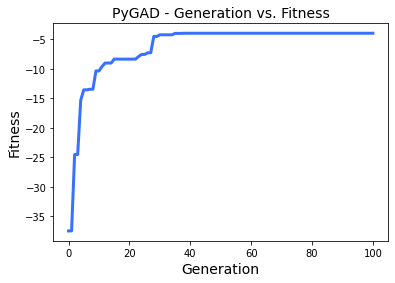

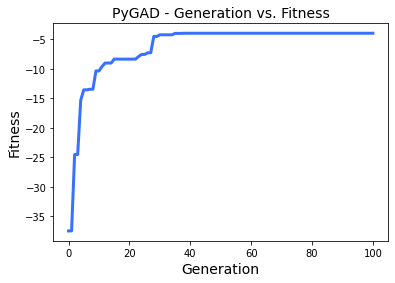

In [71]:
ga_instance.plot_fitness()

In [72]:
def generate_array(start, end, total_length):
    if end < start:
        raise ValueError("The second number must be greater than or equal to the first number.")
    
    if total_length <= 0:
        raise ValueError("The total_length must be a positive integer.")
    
    # Calculate the length of the portion with 0s
    zero_length = min(end - start, total_length)
    
    # Create the array with 1s initially
    result = [1] * total_length
    
    # Set the portion from start to end with 0s
    if zero_length > 0:
        result[start:start + zero_length] = [0] * zero_length
    
    return result

In [73]:
from sklearn.metrics import precision_score, recall_score, f1_score

start_number = outlier_dims[0][0]
end_number = outlier_dims[0][1]
desired_length = 20

result_array = generate_array(start_number, end_number, desired_length)
result_array = np.array(result_array)

# Calculate precision, recall, and F1 score
precision = precision_score(1-result_array, 1-solution)
recall = recall_score(1-result_array, 1-solution)
f1 = f1_score(1-result_array, 1-solution)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [28]:
result_array

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [74]:
for i, outlier_index in enumerate(outlier_inds):
    
    start_number = outlier_dims[i][0]
    end_number = outlier_dims[i][1]
    desired_length = 20

    result_array = generate_array(start_number, end_number, desired_length)
    true_labels = np.array(result_array)
    
    inlier_samples = dataset[:5, :]
    outlier_sample = dataset[outlier_index, :]
    
    ga_instance, solution = run_genetic_on_sample(inlier_samples, 
                                              outlier_sample, 
                                              rae, 
                                              num_dims=20, 
                                              num_generations = 40, 
                                              mutation_probability=0.1)
    
    precision = precision_score(1-true_labels, 1-solution)
    recall = recall_score(1-true_labels, 1-solution)
    f1 = f1_score(1-true_labels, 1-solution)

    # Print the results
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 0.2857142857142857
F1 Score: 0.4444444444444445
Precision: 1.0
Recall: 0.9285714285714286
F1 Score: 0.962962962962963
Precision: 1.0
Recall: 0.2857142857142857
F1 Score: 0.4444444444444445
Precision: 1.0
Recall: 0.21428571428571427
F1 Score: 0.35294117647058826
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 0.14285714285714285
F1 Score: 0.25
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 0.2857142857142857
F1 Score: 0.4444444444444445
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


KeyboardInterrupt: 

In [90]:
dataset[outlier_inds[0]]

array([ 1.72489976,  3.79988545,  4.88669797,  6.78653022,  4.47452789,
        5.58330981,  5.44677174,  9.89295494,  2.74854279,  4.0567402 ,
        7.45260837,  8.22710667,  3.45446456,  4.90834474,  0.408207  ,
        0.93612343,  0.87881386,  0.8002054 ,  0.62412487, -0.31169939])

(0, 14)

# Real World Datasets

In [40]:
def real_world_csv_data_loader(name):

    if name == "10-speech_pca.csv":

        csv_file = './data/10-speech_pca.csv'
        label_csv_files = ['./data_od_evaluation/speech_pca_gt_copod.csv', 
                           './data_od_evaluation/speech_pca_gt_hbos.csv',
                           './data_od_evaluation/speech_pca_gt_iforest.csv']
        data = pd.read_csv(csv_file)

        gt_copod = pd.read_csv(label_csv_files[0])
        gt_hbos = pd.read_csv(label_csv_files[1])
        gt_iforest = pd.read_csv(label_csv_files[2])

        last_column = data.iloc[:, -1].values
        # last_column = np.where(last_column == 0, 0, 1)
        labels = last_column
        data = np.array(data)
        GTs = [gt_copod, gt_hbos, gt_iforest]
        data_n = data[:,:-1]
    
    
    if name == "09-satimage-2_pca.csv":

        csv_file = './data/09-satimage-2_pca.csv'
        label_csv_files = ['./data_od_evaluation/satimage-2_pca_gt_copod.csv', 
                           './data_od_evaluation/satimage-2_pca_gt_hbos.csv',
                           './data_od_evaluation/satimage-2_pca_gt_iforest.csv']
        data = pd.read_csv(csv_file)

        gt_copod = pd.read_csv(label_csv_files[0])
        gt_hbos = pd.read_csv(label_csv_files[1])
        gt_iforest = pd.read_csv(label_csv_files[2])

        last_column = data.iloc[:, -1].values
        # last_column = np.where(last_column == 0, 0, 1)
        labels = last_column
        data = np.array(data)
        GTs = [gt_copod, gt_hbos, gt_iforest]
        data_n = data[:,:-1]
        
        
    if name == "07-arrhythmia_pca.csv":

        csv_file = './data/07-arrhythmia_pca.csv'
        label_csv_files = ['./data_od_evaluation/arrhythmia_pca_gt_copod.csv', 
                           './data_od_evaluation/arrhythmia_pca_gt_hbos.csv',
                           './data_od_evaluation/arrhythmia_pca_gt_iforest.csv']
        data = pd.read_csv(csv_file)

        gt_copod = pd.read_csv(label_csv_files[0])
        gt_hbos = pd.read_csv(label_csv_files[1])
        gt_iforest = pd.read_csv(label_csv_files[2])

        last_column = data.iloc[:, -1].values
        # last_column = np.where(last_column == 0, 0, 1)
        labels = last_column
        data = np.array(data)
        GTs = [gt_copod, gt_hbos, gt_iforest]
        data_n = data[:,:-1]
    
    if name == "02-wineQualityReds-od2.csv":

        csv_file = './data/02-wineQualityReds-od2.csv'
        label_csv_files = ['./data_od_evaluation/wineQualityReds-od2_gt_copod.csv', 
                           './data_od_evaluation/wineQualityReds-od2_gt_hbos.csv',
                           './data_od_evaluation/wineQualityReds-od2_gt_iforest.csv']
        data = pd.read_csv(csv_file)

        gt_copod = pd.read_csv(label_csv_files[0])
        gt_hbos = pd.read_csv(label_csv_files[1])
        gt_iforest = pd.read_csv(label_csv_files[2])

        last_column = data.iloc[:, -1].values
        # last_column = np.where(last_column == 0, 0, 1)
        labels = last_column
        data = np.array(data)
        GTs = [gt_copod, gt_hbos, gt_iforest]
        data_n = data[:,:-1]
        
    if name == "03-wineQualityWhites-od2.csv":

        csv_file = './data/03-wineQualityWhites-od2.csv'
        label_csv_files = ['./data_od_evaluation/wineQualityWhites-od2_gt_copod.csv', 
                           './data_od_evaluation/wineQualityWhites-od2_gt_hbos.csv',
                           './data_od_evaluation/wineQualityWhites-od2_gt_iforest.csv']
        data = pd.read_csv(csv_file)

        gt_copod = pd.read_csv(label_csv_files[0])
        gt_hbos = pd.read_csv(label_csv_files[1])
        gt_iforest = pd.read_csv(label_csv_files[2])

        last_column = data.iloc[:, -1].values
        # last_column = np.where(last_column == 0, 0, 1)
        labels = last_column
        data = np.array(data)
        GTs = [gt_copod, gt_hbos, gt_iforest]
        data_n = data[:,:-1]
    
    if name == "11-optdigits_pca.csv":

        csv_file = './data/11-optdigits_pca.csv'
        label_csv_files = ['./data_od_evaluation/optdigits_pca_gt_copod.csv', 
                           './data_od_evaluation/optdigits_pca_gt_hbos.csv',
                           './data_od_evaluation/optdigits_pca_gt_iforest.csv']
        data = pd.read_csv(csv_file)

        gt_copod = pd.read_csv(label_csv_files[0])
        gt_hbos = pd.read_csv(label_csv_files[1])
        gt_iforest = pd.read_csv(label_csv_files[2])

        last_column = data.iloc[:, -1].values
        # last_column = np.where(last_column == 0, 0, 1)
        labels = last_column
        data = np.array(data)
        GTs = [gt_copod, gt_hbos, gt_iforest]
        data_n = data[:,:-1]
        
    if name == "08-wbc_pca.csv":

        csv_file = './data/08-wbc_pca.csv'
        label_csv_files = ['./data_od_evaluation/wbc_pca_gt_copod.csv', 
                           './data_od_evaluation/wbc_pca_gt_hbos.csv',
                           './data_od_evaluation/wbc_pca_gt_iforest.csv']
        data = pd.read_csv(csv_file)

        gt_copod = pd.read_csv(label_csv_files[0])
        gt_hbos = pd.read_csv(label_csv_files[1])
        gt_iforest = pd.read_csv(label_csv_files[2])

        last_column = data.iloc[:, -1].values
        # last_column = np.where(last_column == 0, 0, 1)
        labels = last_column
        data = np.array(data)
        GTs = [gt_copod, gt_hbos, gt_iforest]
        data_n = data[:,:-1]
    
    if name == "01-vertebral.csv":

        csv_file = './data/01-vertebral.csv'
        label_csv_files = ['./data_od_evaluation/vertebral_gt_copod.csv', 
                           './data_od_evaluation/vertebral_gt_hbos.csv',
                           './data_od_evaluation/vertebral_gt_iforest.csv']
        data = pd.read_csv(csv_file)

        gt_copod = pd.read_csv(label_csv_files[0])
        gt_hbos = pd.read_csv(label_csv_files[1])
        gt_iforest = pd.read_csv(label_csv_files[2])

        last_column = data.iloc[:, -1].values
        # last_column = np.where(last_column == 0, 0, 1)
        labels = last_column
        data = np.array(data)
        GTs = [gt_copod, gt_hbos, gt_iforest]
        data_n = data[:,:-1]
        
    return data_n, labels, GTs

In [41]:
data_n, labels, GTs = real_world_csv_data_loader("01-vertebral.csv")
print(data_n.shape)

(240, 6)


In [44]:
rae, history = train_RAE(data_n,
              latent_dim = 2,
              hidden_layer_n = [8,6,4],
              num_dims = data_n.shape[1],
              z_loss_w = 0.01,
              REG_loss_w = 0.01,
              epochs = 10000,
              batch_size = 128
              )

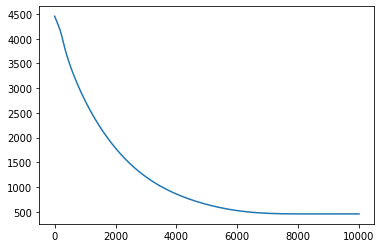

In [45]:
plt.plot(history.history["reconstruction_loss"])
# plt.plot(history.history["z_loss"])
# plt.plot(history.history["REG_loss"])

In [48]:
classes = rae_detect_outliers(data_n, rae, num_dims=data_n.shape[1], std_k=0)

In [49]:
print(np.sum(1-classes))
print(np.sum(labels))
predictions = 1-classes

50
30.0


In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score




# Calculate precision, recall, and F1 score
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.08
Recall: 0.13333333333333333
F1 Score: 0.1


In [51]:
np.where(predictions)

(array([  5,   7,   9,  11,  17,  24,  26,  35,  36,  37,  40,  47,  49,
         53,  54,  61,  71,  75,  76,  83,  85,  92,  95,  96, 104, 107,
        111, 114, 115, 121, 135, 141, 142, 143, 162, 163, 167, 168, 180,
        192, 197, 201, 202, 205, 206, 208, 215, 220, 227, 237]),)

In [52]:
non_zero = np.where(labels != 0)
non_zero[0]

array([210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,
       223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,
       236, 237, 238, 239])

In [67]:
outlier_sample = data_n[0,:]
inlier_samples = data_n[62:64,:]

In [68]:
ga_instance, solution = run_genetic_on_sample(inlier_samples,
                                              outlier_sample, 
                                              rae, 
                                              num_dims=data_n.shape[1], 
                                              num_generations = 100, 
                                              mutation_probability=0.1,
                                              sol_per_pop=20,
                                              crossover_type="uniform")

In [75]:
gt_0 = np.array(GTs[2])
print(gt_0[0,1])
print(solution)

[0, 1]
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]


In [21]:
from sklearn.metrics import precision_score, jaccard_score, auc, roc_curve, precision_recall_curve
from sklearn.metrics import recall_score, f1_score
import random

In [53]:
gt_0 = np.array(GTs[0])
gt_1 = np.array(GTs[1])
gt_2 = np.array(GTs[2])

mean_0_f1 = []
mean_0_recall = []
mean_0_precision = []
mean_0_jaccard = []
mean_0_aupr = []
mean_0_auroc = []

mean_1_f1 = []
mean_1_recall = []
mean_1_precision = []
mean_1_jaccard = []
mean_1_aupr = []
mean_1_auroc = []

mean_2_f1 = []
mean_2_recall = []
mean_2_precision = []
mean_2_jaccard = []
mean_2_aupr = []
mean_2_auroc = []

non_zero = np.where(labels != 0)

for i, out_index in enumerate(non_zero[0]):
    
    outlier_sample = data_n[out_index,:]
    
    random_numbers = [random.randint(0, 4000) for _ in range(3)]
    inlier_samples = data_n[0:3,:]
    
    ga_instance, solution = run_genetic_on_sample(inlier_samples,
                                                  outlier_sample, 
                                                  rae, 
                                                  num_dims=data_n.shape[1], 
                                                  num_generations = 100, 
                                                  mutation_probability=0.1,
                                                  sol_per_pop=20,
                                                  crossover_type="uniform",
                                                  l2_w = 0.01,
                                                  outlier_w = 0.01)
    
    
    #########################################################################################
    label_0 = np.ones(data_n.shape[1])
    index_str_0 = gt_0[i,1]
    index_str_0 = index_str_0.strip('[]')
    indices = index_str_0.split(',')
    valid_indices_0 = [int(index.strip()) for index in indices]
    label_0[valid_indices_0] =0
#     solution = 1 - solution
    # AUROC and AUPR calculation
    fpr, tpr, _ = roc_curve(label_0, solution)
    precision, recall, _ = precision_recall_curve(label_0, solution)
    auroc = auc(fpr, tpr)
    aupr = auc(recall, precision)
    # Precision calculation
    precision = precision_score(label_0, solution)
    # Jaccard index (Intersection over Union) calculation
    jaccard_index = jaccard_score(label_0, solution)
    # Recall calculation
    recall = recall_score(label_0, solution)
    # F1-score calculation
    f1 = f1_score(label_0, solution)
    # Print the results
    mean_0_f1.append(f1)
    mean_0_recall.append(recall)
    mean_0_precision.append(precision)
    mean_0_jaccard.append(jaccard_index)
    mean_0_aupr.append(aupr)
    mean_0_auroc.append(auroc)
    print(i)
    print(solution)
    print(label_0)
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"Jaccard Index: {jaccard_index:.2f}")
    print(f"AUROC: {auroc:.2f}")
    print(f"AUPR: {aupr:.2f}")
    print("%%%%%%")
    #########################################################################################
    label_1 = np.ones(data_n.shape[1])
    index_str_1 = gt_1[i,1]
    index_str_1 = index_str_1.strip('[]')
    indices = index_str_1.split(',')
    valid_indices_1 = [int(index.strip()) for index in indices]
    label_1[valid_indices_1] =0
    # AUROC and AUPR calculation
    fpr, tpr, _ = roc_curve(label_1, solution)
    precision, recall, _ = precision_recall_curve(label_1, solution)
    auroc = auc(fpr, tpr)
    aupr = auc(recall, precision)
    # Precision calculation
    precision = precision_score(label_1, solution)
    # Jaccard index (Intersection over Union) calculation
    jaccard_index = jaccard_score(label_1, solution)
    # Recall calculation
    recall = recall_score(label_1, solution)
    # F1-score calculation
    f1 = f1_score(label_1, solution)
    # Print the results
    mean_1_f1.append(f1)
    mean_1_recall.append(recall)
    mean_1_precision.append(precision)
    mean_1_jaccard.append(jaccard_index)
    mean_1_aupr.append(aupr)
    mean_1_auroc.append(auroc)
    print(i)
    print(solution)
    print(label_1)
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"Jaccard Index: {jaccard_index:.2f}")
    print(f"AUROC: {auroc:.2f}")
    print(f"AUPR: {aupr:.2f}")
    print("%%%%%%")
    #########################################################################################
    label_2 = np.ones(data_n.shape[1])
    index_str_2 = gt_2[i,1]
    index_str_2 = index_str_2.strip('[]')
    indices = index_str_2.split(',')
    valid_indices_2 = [int(index.strip()) for index in indices]
    label_2[valid_indices_2] =0
    # AUROC and AUPR calculation
    fpr, tpr, _ = roc_curve(label_2, solution)
    precision, recall, _ = precision_recall_curve(label_2, solution)
    auroc = auc(fpr, tpr)
    aupr = auc(recall, precision)
    # Precision calculation
    precision = precision_score(label_2, solution)
    # Jaccard index (Intersection over Union) calculation
    jaccard_index = jaccard_score(label_2, solution)
    # Recall calculation
    recall = recall_score(label_2, solution)
    # F1-score calculation
    f1 = f1_score(label_2, solution)
    # Print the results
    mean_2_f1.append(f1)
    mean_2_recall.append(recall)
    mean_2_precision.append(precision)
    mean_2_jaccard.append(jaccard_index)
    mean_2_aupr.append(aupr)
    mean_2_auroc.append(auroc)
    print(i)
    print(solution)
    print(label_2)
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"Jaccard Index: {jaccard_index:.2f}")
    print(f"AUROC: {auroc:.2f}")
    print(f"AUPR: {aupr:.2f}")
    print("#######################################")

    
mean_0_f1 = np.array(mean_0_f1)
mean_0_recall = np.array(mean_0_recall)
mean_0_precision = np.array(mean_0_precision)
mean_0_jaccard = np.array(mean_0_jaccard)
mean_0_aupr = np.array(mean_0_aupr)
mean_0_auroc = np.array(mean_0_auroc)

mean_1_f1 = np.array(mean_1_f1)
mean_1_recall = np.array(mean_1_recall)
mean_1_precision = np.array(mean_1_precision)
mean_1_jaccard = np.array(mean_1_jaccard)
mean_1_aupr = np.array(mean_1_aupr)
mean_1_auroc = np.array(mean_1_auroc)

mean_2_f1 = np.array(mean_2_f1)
mean_2_recall = np.array(mean_2_recall)
mean_2_precision = np.array(mean_2_precision)
mean_2_jaccard = np.array(mean_2_jaccard)
mean_2_aupr = np.array(mean_2_aupr)
mean_2_auroc = np.array(mean_2_auroc)

0
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 0. 1.]
Precision: 0.83
Recall: 1.00
F1-Score: 0.91
Jaccard Index: 0.83
AUROC: 0.50
AUPR: 0.92
%%%%%%
0
[1. 1. 1. 1. 1. 1.]
[0. 1. 0. 1. 1. 1.]
Precision: 0.67
Recall: 1.00
F1-Score: 0.80
Jaccard Index: 0.67
AUROC: 0.50
AUPR: 0.83
%%%%%%
0
[1. 1. 1. 1. 1. 1.]
[0. 1. 1. 1. 1. 1.]
Precision: 0.83
Recall: 1.00
F1-Score: 0.91
Jaccard Index: 0.83
AUROC: 0.50
AUPR: 0.92
#######################################
1
[1. 1. 1. 1. 1. 1.]
[1. 0. 1. 1. 0. 1.]
Precision: 0.67
Recall: 1.00
F1-Score: 0.80
Jaccard Index: 0.67
AUROC: 0.50
AUPR: 0.83
%%%%%%
1
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 0. 1.]
Precision: 0.83
Recall: 1.00
F1-Score: 0.91
Jaccard Index: 0.83
AUROC: 0.50
AUPR: 0.92
%%%%%%
1
[1. 1. 1. 1. 1. 1.]
[1. 0. 1. 1. 1. 1.]
Precision: 0.83
Recall: 1.00
F1-Score: 0.91
Jaccard Index: 0.83
AUROC: 0.50
AUPR: 0.92
#######################################
2
[1. 1. 1. 1. 1. 1.]
[1. 0. 1. 1. 0. 1.]
Precision: 0.67
Recall: 1.00
F1-Score: 0.80
Jaccard Index: 0.67
AUROC: 0.50


/home/ali/anaconda3/envs/deeplab-pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ali/anaconda3/envs/deeplab-pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ali/anaconda3/envs/deeplab-pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 1.]
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
Jaccard Index: 0.00
AUROC: 0.50
AUPR: 0.67
%%%%%%
10
[0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 0. 1.]
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
Jaccard Index: 0.00
AUROC: 0.50
AUPR: 0.92
%%%%%%
10
[0. 0. 0. 0. 0. 0.]
[1. 0. 0. 1. 0. 1.]
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
Jaccard Index: 0.00
AUROC: 0.50
AUPR: 0.75
#######################################
11
[0. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 0. 1.]
Precision: 0.80
Recall: 0.80
F1-Score: 0.80
Jaccard Index: 0.67
AUROC: 0.40
AUPR: 0.88
%%%%%%
11
[0. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 0. 1.]
Precision: 0.80
Recall: 0.80
F1-Score: 0.80
Jaccard Index: 0.67
AUROC: 0.40
AUPR: 0.88
%%%%%%
11
[0. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 0. 1.]
Precision: 0.80
Recall: 0.80
F1-Score: 0.80
Jaccard Index: 0.67
AUROC: 0.40
AUPR: 0.88
#######################################
12
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 0. 0. 1.]
Precision: 0.67
Recall: 1.00
F1-Score: 0.80
Jaccard Index: 0.67
AUROC

29
[1. 1. 1. 0. 1. 1.]
[1. 1. 1. 0. 0. 1.]
Precision: 0.80
Recall: 1.00
F1-Score: 0.89
Jaccard Index: 0.80
AUROC: 0.75
AUPR: 0.90
%%%%%%
29
[1. 1. 1. 0. 1. 1.]
[1. 1. 1. 1. 0. 1.]
Precision: 0.80
Recall: 0.80
F1-Score: 0.80
Jaccard Index: 0.67
AUROC: 0.40
AUPR: 0.88
%%%%%%
29
[1. 1. 1. 0. 1. 1.]
[0. 1. 1. 1. 0. 1.]
Precision: 0.60
Recall: 0.75
F1-Score: 0.67
Jaccard Index: 0.50
AUROC: 0.38
AUPR: 0.76
#######################################


In [54]:
print(np.mean(mean_0_f1))
print(np.mean(mean_0_recall))
print(np.mean(mean_0_precision))
print(np.mean(mean_0_jaccard))
print(np.mean(mean_0_aupr))
print(np.mean(mean_0_auroc))
print("###################")

print(np.mean(mean_1_f1))
print(np.mean(mean_1_recall))
print(np.mean(mean_1_precision))
print(np.mean(mean_1_jaccard))
print(np.mean(mean_1_aupr))
print(np.mean(mean_1_auroc))
print("###################")

print(np.mean(mean_2_f1))
print(np.mean(mean_2_recall))
print(np.mean(mean_2_precision))
print(np.mean(mean_2_jaccard))
print(np.mean(mean_2_aupr))
print(np.mean(mean_2_auroc))

0.7713588263588265
0.81
0.77
0.6688888888888889
0.862222222222222
0.6786111111111112
###################
0.7665151515151517
0.7333333333333335
0.8555555555555556
0.6611111111111111
0.9194444444444443
0.6166666666666667
###################
0.7178403078403081
0.7411111111111113
0.7472222222222222
0.5950000000000001
0.849722222222222
0.5927777777777778


In [102]:
label_0

array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0.])

In [98]:
test = np.ones(data_n.shape[1])

index_str = gt_0[0,1]

index_str = index_str.strip('[]')
indices = index_str.split(',')

# Convert indices to integers
valid_indices = [int(index.strip()) for index in indices]

test[valid_indices] = 0

print(test)

[1. 0. 1. 1. 0. 1. 1. 1. 1. 1.]


In [96]:
gt_0[0,1]

'[1, 4]'